# 1. Augmentation을 적용한 데이터셋 만들기

목차

1. 데이터셋 불러오기
2. 데이터셋 전처리
3. 데이터셋 증강 (augmentations)
4. 데이터셋 제작하기

## 데이터셋 불러오기

1. 라이브러리 불러오기
2. 컴퓨터 그래픽 확인
3. 데이터셋 load 및 정보 확인

In [1]:
# library 불러오기
import tensorflow as tf
import numpy as np
from tensorflow import keras
import matplotlib.pyplot as plt
import pandas as pd

import tensorflow_datasets as tfds

print(tf.__version__)
print(np.__version__)

2.6.0
1.21.4


In [2]:
(ds_train, ds_test), ds_info = tfds.load(
    'stanford_dogs',
    split=['train', 'test'],
    as_supervised=True,
    shuffle_files=True,
    with_info=True,
)

In [3]:
# Tensorflow 데이터셋을 로드하면 꼭 feature 정보를 확인해 보세요. 
print(ds_info.features)

FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=tf.uint8),
    'image/filename': Text(shape=(), dtype=tf.string),
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=120),
    'objects': Sequence({
        'bbox': BBoxFeature(shape=(4,), dtype=tf.float32),
    }),
})


In [4]:
# 데이터의 개수도 확인해 봅시다. 
print(tf.data.experimental.cardinality(ds_train))  # tf.Tensor(12000, shape=(), dtype=int64)
print(tf.data.experimental.cardinality(ds_test))  # tf.Tensor(537, shape=(), dtype=int64)

tf.Tensor(12000, shape=(), dtype=int64)
tf.Tensor(8580, shape=(), dtype=int64)


In [5]:
NUM_CLASSES = ds_info.features["label"].num_classes
NUM_CLASSES  # 120

120

In [6]:
ds_info.features["label"].names

['n02085620-chihuahua',
 'n02085782-japanese_spaniel',
 'n02085936-maltese_dog',
 'n02086079-pekinese',
 'n02086240-shih-tzu',
 'n02086646-blenheim_spaniel',
 'n02086910-papillon',
 'n02087046-toy_terrier',
 'n02087394-rhodesian_ridgeback',
 'n02088094-afghan_hound',
 'n02088238-basset',
 'n02088364-beagle',
 'n02088466-bloodhound',
 'n02088632-bluetick',
 'n02089078-black-and-tan_coonhound',
 'n02089867-walker_hound',
 'n02089973-english_foxhound',
 'n02090379-redbone',
 'n02090622-borzoi',
 'n02090721-irish_wolfhound',
 'n02091032-italian_greyhound',
 'n02091134-whippet',
 'n02091244-ibizan_hound',
 'n02091467-norwegian_elkhound',
 'n02091635-otterhound',
 'n02091831-saluki',
 'n02092002-scottish_deerhound',
 'n02092339-weimaraner',
 'n02093256-staffordshire_bullterrier',
 'n02093428-american_staffordshire_terrier',
 'n02093647-bedlington_terrier',
 'n02093754-border_terrier',
 'n02093859-kerry_blue_terrier',
 'n02093991-irish_terrier',
 'n02094114-norfolk_terrier',
 'n02094258-norwi

train set 정보 확인

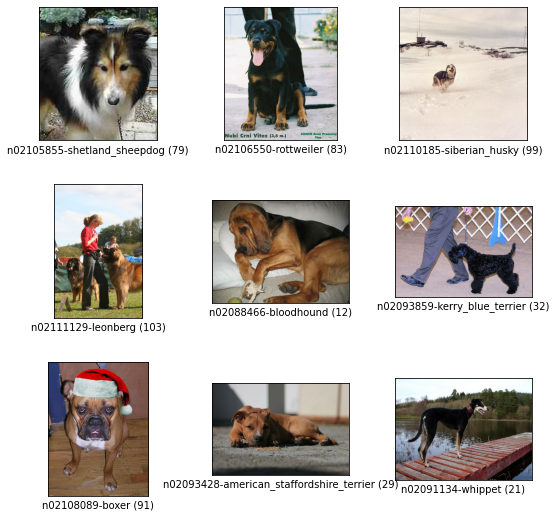

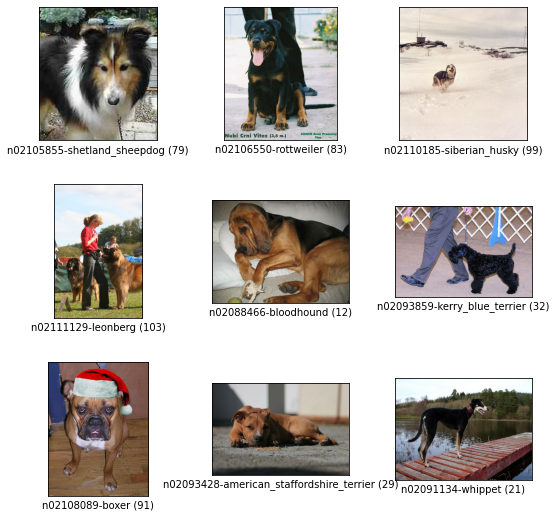

In [7]:
tfds.show_examples(ds_train, ds_info)

test set 정보 확인

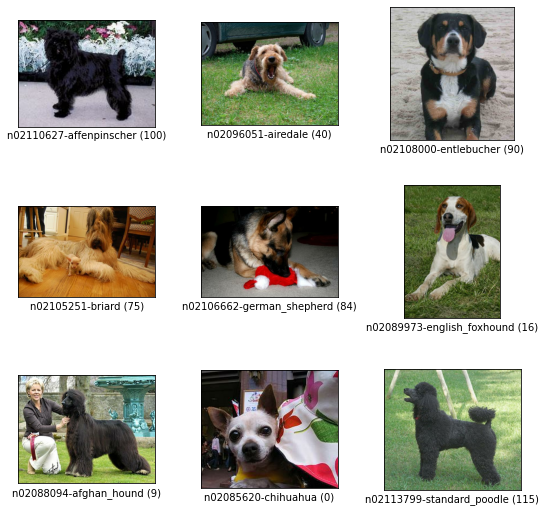

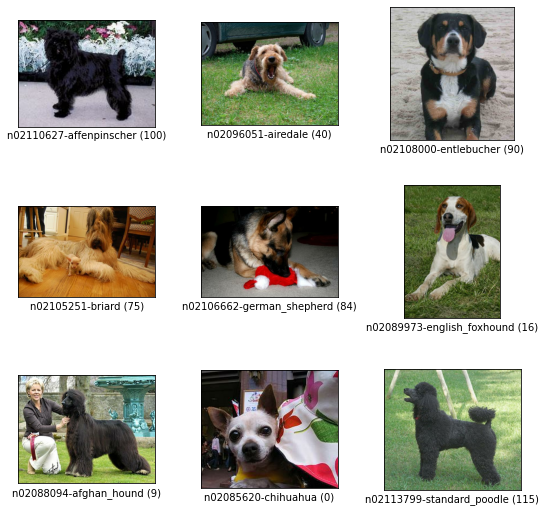

In [8]:
tfds.show_examples(ds_test, ds_info)

## 데이터셋 전처리 (Pre-processing)
1. 전처리 함수 구현

In [9]:
def normalize_and_resize_img(image, label):
    # Normalizes images: `uint8` -> `float32`
    image = tf.image.resize(image, [224, 224])
    image = tf.cast(image, tf.float32) / 255.
    return image, label

## 데이터셋 증강 (Augmentation)

1. no augmentation
2. normal augmentation
3. Cut-Mix augmentation
4. Mix-up augmentation

### Augmentations
no augmentation and normal augmentation

In [10]:
def augment(image,label):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_brightness(image, max_delta=0.2)
    image = tf.clip_by_value(image, 0, 1)
    return image, label

### Cutmix Augmentation

일정 영역을 잘라서 이미지를 잘라서 붙여주는 기법이고, 이미지 섞기 와 라벨 섞기가 있습니다.


이미지 섞기의 예시로는 바운딩 박스가 있습니다. 바운딩 박스는 이미지에서 잘라서 섞어주는 영역으로 표시하고, 바운딩 박스의 위치를 랜덤하게 뽑고 잘라내서 두개의 이미지를 섞어줍니다.

라벨 섞기는 면적에 비례해서 라벨을 섞고, 라벨 벡터는 각 클래스에 해당하는 인덱스에 적절한 비율을 배분하는 방식을 사용합니다.

In [11]:
def get_clip_box(image_a, image_b):
    # image.shape = (height, width, channel)
    image_size_x = image_a.shape[1]
    image_size_y = image_a.shape[0]
    
    # get center of box
    x = tf.cast(tf.random.uniform([], 0, image_size_x), tf.int32)
    y = tf.cast(tf.random.uniform([], 0, image_size_y), tf.int32)

    # get width, height of box
    width = tf.cast(image_size_x*tf.math.sqrt(1-tf.random.uniform([], 0, 1)), tf.int32)
    height = tf.cast(image_size_y*tf.math.sqrt(1-tf.random.uniform([], 0, 1)), tf.int32)
    
    # clip box in image and get minmax bbox
    x_min = tf.math.maximum(0, x-width//2)
    y_min = tf.math.maximum(0, y-height//2)
    x_max = tf.math.minimum(image_size_x, x+width//2)
    y_max = tf.math.minimum(image_size_y, y+width//2)
    
    return x_min, y_min, x_max, y_max

In [12]:
# mix two images
def mix_2_images(image_a, image_b, x_min, y_min, x_max, y_max):
    image_size_x = image_a.shape[1]
    image_size_y = image_a.shape[0] 
    middle_left = image_a[y_min:y_max, 0:x_min, :] # image_b의 왼쪽 바깥 영역
    middle_center = image_b[y_min:y_max, x_min:x_max, :]  # image_b의 안쪽 영역
    middle_right = image_a[y_min:y_max, x_max:image_size_x, :] # image_b의 오른쪽 바깥 영역
    middle = tf.concat([middle_left,middle_center,middle_right], axis=1)
    top = image_a[0:y_min, :, :]
    bottom = image_a[y_max:image_size_y, :, :]
    mixed_img = tf.concat([top, middle, bottom],axis=0)
    
    return mixed_img

In [13]:
# mix two labels
def mix_2_labels(image_a, label_a, label_b, x_min, y_min, x_max, y_max, num_classes=120):
    image_size_x = image_a.shape[1]
    image_size_y = image_a.shape[0] 
    mixed_area = (x_max-x_min)*(y_max-y_min)
    total_area = image_size_x*image_size_y
    ratio = tf.cast(mixed_area/total_area, tf.float32)

    if len(label_a.shape)==0:
        label_a = tf.one_hot(label_a, num_classes)
    if len(label_b.shape)==0:
        label_b = tf.one_hot(label_b, num_classes)
    mixed_label = (1-ratio)*label_a + ratio*label_b
    return mixed_label

In [14]:
def cutmix(image, label, prob=1.0, batch_size=16, img_size=224, num_classes=120):
    mixed_imgs = []
    mixed_labels = []

    for i in range(batch_size):
        image_a = image[i]
        label_a = label[i]
        j = tf.cast(tf.random.uniform([],0, batch_size),tf.int32)
        image_b = image[j]
        label_b = label[j]
        x_min, y_min, x_max, y_max = get_clip_box(image_a, image_b)
        mixed_imgs.append(mix_2_images(image_a, image_b, x_min, y_min, x_max, y_max))
        mixed_labels.append(mix_2_labels(image_a, label_a, label_b, x_min, y_min, x_max, y_max))

    mixed_imgs = tf.reshape(tf.stack(mixed_imgs), (batch_size, img_size, img_size, 3))
    mixed_labels = tf.reshape(tf.stack(mixed_labels), (batch_size, num_classes))
    return mixed_imgs, mixed_labels

print('GO')

GO


### Mixup Augmentation

두 이미지와 라벨을 섞을 때, 일정한 범위에서 무작위로 정한 비율을 기준으로 이미지의 픽셀 값 하나하나와 라벨을 각각 그 비율에 맞게 조합하여 새로운 학습 데이터를 생성합니다.

In [15]:
# function for mixup
def mixup_2_images(image_a, image_b, label_a, label_b, num_classes=120):
    ratio = tf.random.uniform([], 0, 1)
    
    if len(label_a.shape)==0:
        label_a = tf.one_hot(label_a, num_classes)
    if len(label_b.shape)==0:
        label_b = tf.one_hot(label_b, num_classes)
    mixed_image= (1-ratio)*image_a + ratio*image_b
    mixed_label = (1-ratio)*label_a + ratio*label_b
    
    return mixed_image, mixed_label

In [16]:
def mixup(image, label, prob=1.0, batch_size=16, img_size=224, num_classes=120):
    mixed_imgs = []
    mixed_labels = []

    for i in range(batch_size):
        image_a = image[i]
        label_a = label[i]
        j = tf.cast(tf.random.uniform([],0,batch_size), tf.int32)
        image_b = image[j]
        label_b = label[j]
        mixed_img, mixed_label = mixup_2_images(image_a, image_b, label_a, label_b)
        mixed_imgs.append(mixed_img)
        mixed_labels.append(mixed_label)

    mixed_imgs = tf.reshape(tf.stack(mixed_imgs), (batch_size, img_size, img_size, 3))
    mixed_labels = tf.reshape(tf.stack(mixed_labels), (batch_size, num_classes))
    return mixed_imgs, mixed_labels

## 데이터셋 만들기

cutmix, mixup augmentation 등이 적용 될 수 있도록 sparse_categoricalcorssentropy 대신 one-hot encoding을 하여 정수가 아닌 부동소수점으로 표현 해줍니다.

In [17]:
def onehot(image, label, num_classes=120):
    label_one_hot = tf.one_hot(label, num_classes)
    return image, label_one_hot

In [18]:
# 데이터셋(ds)을 가공하는 메인함수
def apply_normalize_on_dataset(ds, is_test=False, batch_size=16, with_aug=False, with_cutmix=False, with_mixup=False):
    ds = ds.map(
        normalize_and_resize_img,  # normalizing 과 resizing 적용
        num_parallel_calls=2
    )
    if not is_test and with_aug:
        ds = ds.map(
            augment  # augment 함수 적용
        )
    ds = ds.batch(batch_size)
    if not is_test and with_cutmix:
        ds = ds.map(
            cutmix,  # cutmix augment 함수 적용
            num_parallel_calls=2
        )
    elif not is_test and with_mixup:
        ds = ds.map(
            mixup,  # mixup augment 함수 적용
            num_parallel_calls=2
        )
    else:
        ds = ds.map(
            onehot,  # one - hot encoding
            num_parallel_calls=2
        )
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

print('GO')

GO


In [19]:
# BATCH_SIZE = 16

strategy = tf.distribute.MirroredStrategy()
BATCH_SIZE = 16 * strategy.num_replicas_in_sync

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)


INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)


In [20]:
ds_train_no_aug = apply_normalize_on_dataset(ds_train, batch_size=BATCH_SIZE, with_aug=False)
ds_train_aug = apply_normalize_on_dataset(ds_train, batch_size=BATCH_SIZE, with_aug=True)
ds_train_aug_cutmix = apply_normalize_on_dataset(ds_train, batch_size=BATCH_SIZE, with_cutmix=True)
ds_train_aug_mixup = apply_normalize_on_dataset(ds_train, batch_size=BATCH_SIZE, with_mixup=True)
ds_test = apply_normalize_on_dataset(ds_test, is_test=True, batch_size=BATCH_SIZE)
print('GO')

GO


## 이미지 확인

In [21]:
# 데이터셋에서 이미지 가져와서 시각화
def draw_ds_train(ds_train, batch_size=16, row=6, col=4):
    row = min(row, batch_size//col)  # row 재설정
    
    # 데이터셋에서 배치 사이즈(=16개)만큼 1번만 이미지 가져오기
    for i, (image, label) in enumerate(ds_train.take(1)):
        
        plt.figure(figsize=(8,int(8*row/col)))  # 8x8 크기
        for j in range(row*col):
            plt.subplot(row,col,j+1)
            plt.axis('off')
            plt.imshow(image[j,])  # 가져온 이미지(16개) 하나씩 출력
                    
        plt.tight_layout()
        plt.show()

### No Augmentation

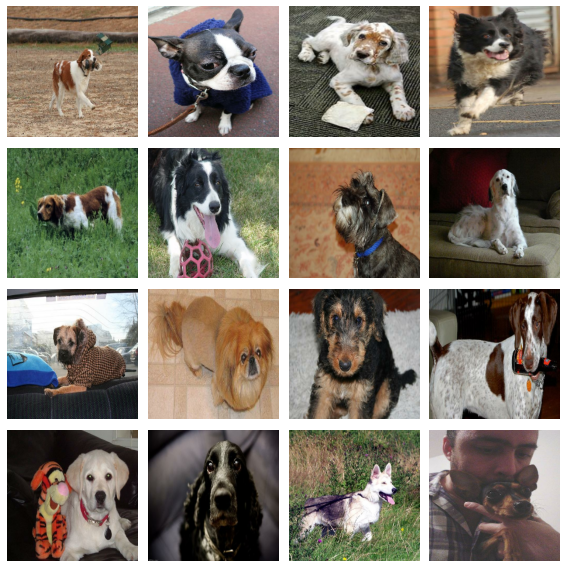

In [22]:
draw_ds_train(ds_train_no_aug, BATCH_SIZE)

### Augmentation

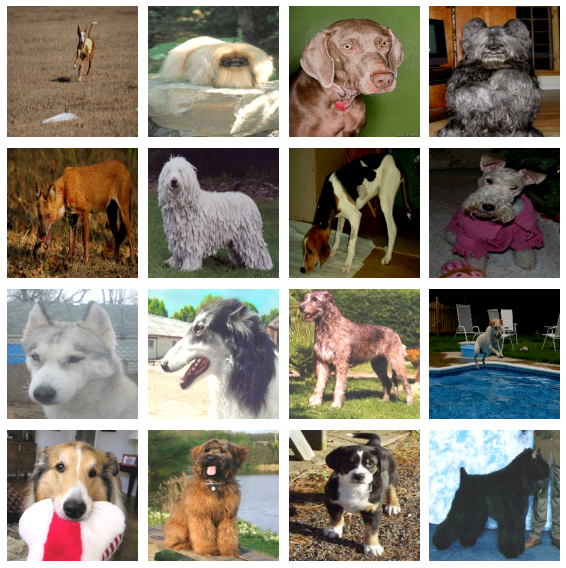

In [23]:
draw_ds_train(ds_train_aug, BATCH_SIZE)

### CutMix

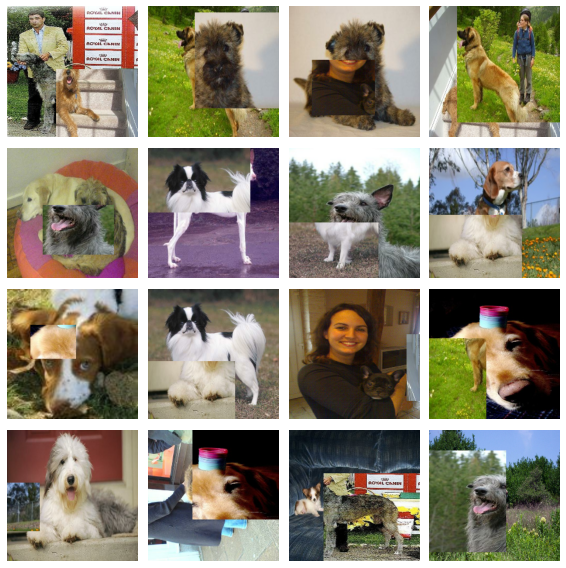

In [24]:
draw_ds_train(ds_train_aug_cutmix, BATCH_SIZE)

### Mixup

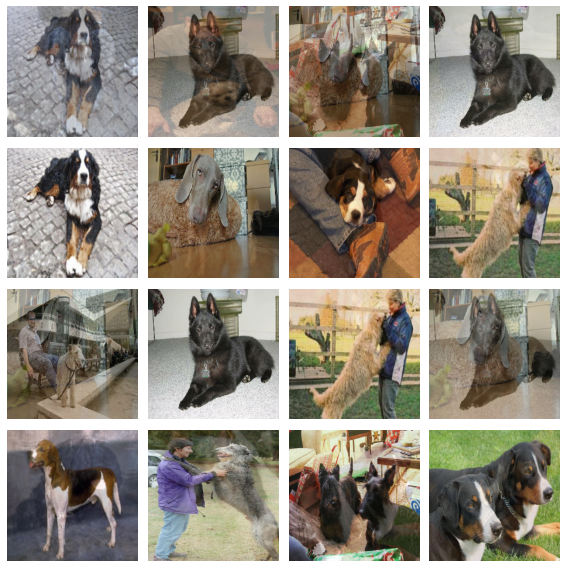

In [25]:
draw_ds_train(ds_train_aug_mixup, BATCH_SIZE)

# 2. ResNet 50 모델 만들기

1. No Augmentation
2. Baseline Augmentation
3. Model 1 (Baseline + Cutmix Augmentation)
4. Model 2 (Baseline + Mixup Augmentation)


### 1. ResNet50 Model-based

In [26]:
def create_ResNet50(include_top=False,
                    weights='imagenet',
                    input_shape=(224,224,3),
                    pooling='avg',
                    num_classes=120,
                    activation='softmax'):
                    
    resnet50 = keras.models.Sequential([
        keras.applications.resnet.ResNet50(
            include_top=include_top,
            weights=weights,
            input_shape=input_shape,
            pooling=pooling,
        ),
        keras.layers.Dense(num_classes, activation=activation)
    ])
    return resnet50

### 2. Model Applications

In [27]:
noaugmentation = create_ResNet50(num_classes=NUM_CLASSES)  # no augmentation 으로 학습시킬 ResNet
augmentation = create_ResNet50(num_classes=NUM_CLASSES)  # augmentation 으로 학습시킬 ResNet
Model1 = create_ResNet50(num_classes=NUM_CLASSES)  # cutmix augmentation 으로 학습시킬 ResNet
Model2 = create_ResNet50(num_classes=NUM_CLASSES)  # mixup augmentation 으로 학습시킬 ResNet

### 3. Model Compile

In [28]:
def compile_and_fit(resnet50,
                    ds_train,
                    ds_test,
                    ds_info,
                    learning_rate=0.01,
                    batch_size=16,
                    epochs=3):
                    
    resnet50.compile(
        loss='categorical_crossentropy',
        optimizer='sgd',
        metrics=['accuracy'],
    )

    history_resnet50 = resnet50.fit(
        ds_train, # augmentation 적용하지 않은 데이터셋 사용
        steps_per_epoch=int(ds_info.splits['train'].num_examples/batch_size),
        validation_steps=int(ds_info.splits['test'].num_examples/batch_size),
        epochs=epochs,
        callbacks=[lr_callback],
        validation_data=ds_test,
        verbose=1,
        use_multiprocessing=True,
    )

    return history_resnet50

# 3. Training Models

In [29]:
# epoch 설정
EPOCH= 20
LEARNING_RATE=0.01

Learning rate schedule: 0.001 to 0.05 to 0.000819


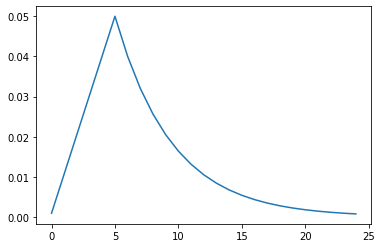

In [30]:

# Learning rate schedule for TPU, GPU and CPU.
# Using an LR ramp up because fine-tuning a pre-trained model.
# Starting with a high LR would break the pre-trained weights.

LR_START = 0.001  # 0.00001
LR_MAX = 0.05 * strategy.num_replicas_in_sync  # 0.00005
LR_MIN = 0.0001  # 0.00001
LR_RAMPUP_EPOCHS = 5
LR_SUSTAIN_EPOCHS = 0
LR_EXP_DECAY = .8

def lrfn(epoch):
    if epoch < LR_RAMPUP_EPOCHS:
        lr = (LR_MAX - LR_START) / LR_RAMPUP_EPOCHS * epoch + LR_START
    elif epoch < LR_RAMPUP_EPOCHS + LR_SUSTAIN_EPOCHS:
        lr = LR_MAX
    else:
        lr = (LR_MAX - LR_MIN) * LR_EXP_DECAY**(epoch - LR_RAMPUP_EPOCHS - LR_SUSTAIN_EPOCHS) + LR_MIN
    return lr
    
lr_callback = tf.keras.callbacks.LearningRateScheduler(lrfn, verbose = True)

rng = [i for i in range(25 if EPOCH<25 else EPOCH)]
y = [lrfn(x) for x in rng]
plt.plot(rng, y)
print("Learning rate schedule: {:.3g} to {:.3g} to {:.3g}".format(y[0], max(y), y[-1]))

No augmentation

In [ ]:
history_resnet50_no_aug = compile_and_fit(
    noaugmentation,
    ds_train_no_aug,
    ds_test,
    ds_info,
    LEARNING_RATE,
    BATCH_SIZE,
    EPOCH
)

Epoch 1/20

Epoch 00001: LearningRateScheduler setting learning rate to 0.001.


In [31]:
# history_resnet50_no_aug 학습 로그에서 데이터 추출
h_resnet50_no_aug_data = [
    # Epoch 1: loss, accuracy, val_loss, val_accuracy
    [4.4498, 0.0791, 4.6109, 0.0549],  # Epoch 1
    [1.7426, 0.5365, 1.7296, 0.5260],  # Epoch 2
    [0.9585, 0.7178, 2.0077, 0.4813],  # Epoch 3
    [0.7674, 0.7692, 2.4431, 0.4377],  # Epoch 4
    [0.8989, 0.7333, 3.3692, 0.2852],  # Epoch 5
    [0.8381, 0.7488, 3.6378, 0.2759],  # Epoch 6
    [0.2297, 0.9330, 1.4602, 0.6364],  # Epoch 7
    [0.0350, 0.9928, 1.3154, 0.6763],  # Epoch 8
    [0.0088, 0.9990, 1.2331, 0.6937],  # Epoch 9
    [0.0085, 0.9992, 1.2300, 0.6983],  # Epoch 10
    [0.0029, 0.9999, 1.2225, 0.6976],  # Epoch 11
    [0.0021, 1.0000, 1.2256, 0.6975],  # Epoch 12
    [0.0023, 0.9998, 1.2244, 0.6978],  # Epoch 13
    [0.0017, 1.0000, 1.2301, 0.6972],  # Epoch 14
    [0.0018, 1.0000, 1.2216, 0.6973],  # Epoch 15
    [0.0019, 0.9999, 1.2272, 0.6979],  # Epoch 16
    [0.0017, 1.0000, 1.2236, 0.6980],  # Epoch 17
    [0.0017, 0.9999, 1.2220, 0.6978],  # Epoch 18
    [0.0018, 0.9999, 1.2243, 0.6989],  # Epoch 19
    [0.0017, 0.9999, 1.2281, 0.6990]   # Epoch 20
]

# Keras History 객체의 .history 와 유사한 딕셔너리 생성
history_resnet50_no_aug = {'loss': [], 'accuracy': [], 'val_loss': [], 'val_accuracy': []}

for i in range(len(h_resnet50_no_aug_data)): # 에포크 수만큼 반복 (20회)
    history_resnet50_no_aug['loss'].append(h_resnet50_no_aug_data[i][0])
    history_resnet50_no_aug['accuracy'].append(h_resnet50_no_aug_data[i][1])
    history_resnet50_no_aug['val_loss'].append(h_resnet50_no_aug_data[i][2])
    history_resnet50_no_aug['val_accuracy'].append(h_resnet50_no_aug_data[i][3])

# # 저장된 데이터 확인 (예: loss 리스트 전체 출력)
# print("Loss:", history_resnet50_no_aug['loss'])
# print("Accuracy:", history_resnet50_no_aug['accuracy'])
# print("Validation Loss:", history_resnet50_no_aug['val_loss'])
# print("Validation Accuracy:", history_resnet50_no_aug['val_accuracy'])

Augmentation

In [35]:
history_resnet50_aug = compile_and_fit(
    augmentation,
    ds_train_aug,
    ds_test,
    ds_info,
    LEARNING_RATE,
    BATCH_SIZE,
    EPOCH
)

Epoch 1/20

Epoch 00001: LearningRateScheduler setting learning rate to 0.001.
750/750 [==============================] - 156s 199ms/step - loss: 4.4861 - accuracy: 0.0749 - val_loss: 4.5248 - val_accuracy: 0.0596
Epoch 2/20

Epoch 00002: LearningRateScheduler setting learning rate to 0.0108.
750/750 [==============================] - 149s 198ms/step - loss: 1.8299 - accuracy: 0.5153 - val_loss: 1.3866 - val_accuracy: 0.5972
Epoch 3/20

Epoch 00003: LearningRateScheduler setting learning rate to 0.0206.
750/750 [==============================] - 149s 198ms/step - loss: 1.2155 - accuracy: 0.6434 - val_loss: 1.7202 - val_accuracy: 0.5478
Epoch 4/20

Epoch 00004: LearningRateScheduler setting learning rate to 0.0304.
750/750 [==============================] - 149s 198ms/step - loss: 1.1010 - accuracy: 0.6776 - val_loss: 2.9383 - val_accuracy: 0.3533
Epoch 5/20

Epoch 00005: LearningRateScheduler setting learning rate to 0.0402.
750/750 [==============================] - 149s 198ms/step - 

In [32]:
# history_resnet50_aug 학습 로그에서 데이터 추출
h_resnet50_aug_data = [
    # Epoch 1: loss, accuracy, val_loss, val_accuracy
    [4.4861, 0.0749, 4.5248, 0.0596],  # Epoch 1
    [1.8299, 0.5153, 1.3866, 0.5972],  # Epoch 2
    [1.2155, 0.6434, 1.7202, 0.5478],  # Epoch 3
    [1.1010, 0.6776, 2.9383, 0.3533],  # Epoch 4
    [1.0979, 0.6747, 2.6908, 0.3846],  # Epoch 5
    [1.0303, 0.6927, 3.7456, 0.2383],  # Epoch 6
    [0.4126, 0.8734, 1.7964, 0.5714],  # Epoch 7
    [0.1128, 0.9712, 1.4621, 0.6370],  # Epoch 8
    [0.0414, 0.9924, 1.2344, 0.6950],  # Epoch 9
    [0.0219, 0.9962, 1.2912, 0.6831],  # Epoch 10
    [0.0122, 0.9985, 1.1893, 0.7079],  # Epoch 11
    [0.0089, 0.9992, 1.1854, 0.7104],  # Epoch 12
    [0.0071, 0.9992, 1.1692, 0.7136],  # Epoch 13
    [0.0060, 0.9997, 1.1662, 0.7144],  # Epoch 14
    [0.0049, 0.9998, 1.1659, 0.7168],  # Epoch 15
    [0.0048, 0.9997, 1.1694, 0.7163],  # Epoch 16
    [0.0043, 1.0000, 1.1658, 0.7169],  # Epoch 17
    [0.0045, 0.9999, 1.1679, 0.7163],  # Epoch 18
    [0.0040, 0.9999, 1.1659, 0.7172],  # Epoch 19
    [0.0038, 0.9999, 1.1679, 0.7171]   # Epoch 20
]

# Keras History 객체의 .history 와 유사한 딕셔너리 생성
history_resnet50_aug = {'loss': [], 'accuracy': [], 'val_loss': [], 'val_accuracy': []}

for i in range(len(h_resnet50_aug_data)): # 에포크 수만큼 반복 (20회)
    history_resnet50_aug['loss'].append(h_resnet50_aug_data[i][0])
    history_resnet50_aug['accuracy'].append(h_resnet50_aug_data[i][1])
    history_resnet50_aug['val_loss'].append(h_resnet50_aug_data[i][2])
    history_resnet50_aug['val_accuracy'].append(h_resnet50_aug_data[i][3])

# # 저장된 데이터 확인 (예: val_accuracy 리스트 전체 출력)
# print("Validation Accuracy (Augmentation):", history_resnet50_aug['val_accuracy'])

Model 1 

In [33]:
history_resnet50_aug_cutmix = compile_and_fit(
    Model1,
    ds_train_aug_cutmix,
    ds_test,
    ds_info,
    LEARNING_RATE,
    BATCH_SIZE,
    EPOCH
)

Epoch 1/20

Epoch 00001: LearningRateScheduler setting learning rate to 0.001.
750/750 [==============================] - 217s 201ms/step - loss: 4.8255 - accuracy: 0.0227 - val_loss: 5.0135 - val_accuracy: 0.0178
Epoch 2/20

Epoch 00002: LearningRateScheduler setting learning rate to 0.0108.
750/750 [==============================] - 151s 201ms/step - loss: 3.5569 - accuracy: 0.2749 - val_loss: 1.8632 - val_accuracy: 0.4983
Epoch 3/20

Epoch 00003: LearningRateScheduler setting learning rate to 0.0206.
750/750 [==============================] - 151s 202ms/step - loss: 3.0292 - accuracy: 0.3959 - val_loss: 1.9621 - val_accuracy: 0.4819
Epoch 4/20

Epoch 00004: LearningRateScheduler setting learning rate to 0.0304.
750/750 [==============================] - 151s 202ms/step - loss: 2.8566 - accuracy: 0.4482 - val_loss: 1.9901 - val_accuracy: 0.4757
Epoch 5/20

Epoch 00005: LearningRateScheduler setting learning rate to 0.0402.
750/750 [==============================] - 167s 223ms/step - 

In [36]:
# history_resnet50_aug_cutmix 학습 로그에서 데이터 추출
h_resnet50_aug_cutmix_data = [
    # Epoch 1: loss, accuracy, val_loss, val_accuracy
    [4.8255, 0.0227, 5.0135, 0.0178],  # Epoch 1
    [3.5569, 0.2749, 1.8632, 0.4983],  # Epoch 2
    [3.0292, 0.3959, 1.9621, 0.4819],  # Epoch 3
    [2.8566, 0.4482, 1.9901, 0.4757],  # Epoch 4
    [2.7369, 0.4850, 2.2518, 0.4220],  # Epoch 5
    [2.6596, 0.5042, 2.4831, 0.3949],  # Epoch 6
    [2.3208, 0.6166, 1.7013, 0.5584],  # Epoch 7
    [2.0707, 0.7047, 1.7316, 0.5597],  # Epoch 8
    [1.8863, 0.7503, 1.5320, 0.6157],  # Epoch 9
    [1.7509, 0.7977, 1.4596, 0.6346],  # Epoch 10
    [1.6717, 0.8112, 1.3994, 0.6655],  # Epoch 11
    [1.6129, 0.8192, 1.5561, 0.6326],  # Epoch 12
    [1.5446, 0.8377, 1.5307, 0.6410],  # Epoch 13
    [1.4981, 0.8453, 1.4122, 0.6750],  # Epoch 14
    [1.4881, 0.8451, 1.3493, 0.6938],  # Epoch 15
    [1.4558, 0.8453, 1.3523, 0.6930],  # Epoch 16
    [1.4619, 0.8408, 1.3335, 0.7011],  # Epoch 17
    [1.4262, 0.8528, 1.3546, 0.7002],  # Epoch 18
    [1.4086, 0.8461, 1.3537, 0.6985],  # Epoch 19
    [1.3958, 0.8601, 1.3705, 0.7032]   # Epoch 20
]

# Keras History 객체의 .history 와 유사한 딕셔너리 생성
history_resnet50_aug_cutmix = {'loss': [], 'accuracy': [], 'val_loss': [], 'val_accuracy': []}

for i in range(len(h_resnet50_aug_cutmix_data)): # 에포크 수만큼 반복 (20회)
    history_resnet50_aug_cutmix['loss'].append(h_resnet50_aug_cutmix_data[i][0])
    history_resnet50_aug_cutmix['accuracy'].append(h_resnet50_aug_cutmix_data[i][1])
    history_resnet50_aug_cutmix['val_loss'].append(h_resnet50_aug_cutmix_data[i][2])
    history_resnet50_aug_cutmix['val_accuracy'].append(h_resnet50_aug_cutmix_data[i][3])

# # 저장된 데이터 확인 (예: val_loss 리스트 전체 출력)
# print("Validation Loss (CutMix Augmentation):", history_resnet50_aug_cutmix['val_loss'])
# print("Validation Accuracy (CutMix Augmentation):", history_resnet50_aug_cutmix['val_accuracy'])

Model 2

In [34]:
history_resnet50_aug_mixup = compile_and_fit(
    Model2,
    ds_train_aug_mixup,
    ds_test,
    ds_info,
    LEARNING_RATE,
    BATCH_SIZE,
    EPOCH
)

Epoch 1/20

Epoch 00001: LearningRateScheduler setting learning rate to 0.001.
750/750 [==============================] - 161s 203ms/step - loss: 4.8450 - accuracy: 0.0278 - val_loss: 5.2838 - val_accuracy: 0.0164
Epoch 2/20

Epoch 00002: LearningRateScheduler setting learning rate to 0.0108.
750/750 [==============================] - 152s 202ms/step - loss: 3.4953 - accuracy: 0.2815 - val_loss: 1.7392 - val_accuracy: 0.5180
Epoch 3/20

Epoch 00003: LearningRateScheduler setting learning rate to 0.0206.
750/750 [==============================] - 151s 202ms/step - loss: 3.0052 - accuracy: 0.4323 - val_loss: 2.1183 - val_accuracy: 0.4653
Epoch 4/20

Epoch 00004: LearningRateScheduler setting learning rate to 0.0304.
750/750 [==============================] - 152s 202ms/step - loss: 2.8448 - accuracy: 0.4764 - val_loss: 2.3049 - val_accuracy: 0.4044
Epoch 5/20

Epoch 00005: LearningRateScheduler setting learning rate to 0.0402.
750/750 [==============================] - 152s 203ms/step - 

In [37]:
# history_resnet50_aug_mixup 학습 로그에서 데이터 추출 (Model2 사용)
h_resnet50_aug_mixup_data_model2 = [
    # Epoch 1: loss, accuracy, val_loss, val_accuracy
    [4.8450, 0.0278, 5.2838, 0.0164],  # Epoch 1
    [3.4953, 0.2815, 1.7392, 0.5180],  # Epoch 2
    [3.0052, 0.4323, 2.1183, 0.4653],  # Epoch 3
    [2.8448, 0.4764, 2.3049, 0.4044],  # Epoch 4
    [2.7192, 0.5267, 2.5064, 0.3821],  # Epoch 5
    [2.6086, 0.5627, 2.7874, 0.3300],  # Epoch 6
    [2.3029, 0.6766, 1.8441, 0.5241],  # Epoch 7
    [2.0526, 0.7689, 1.6599, 0.5705],  # Epoch 8
    [1.9234, 0.8173, 1.3987, 0.6277],  # Epoch 9
    [1.8306, 0.8436, 1.3093, 0.6613],  # Epoch 10
    [1.7466, 0.8668, 1.4531, 0.6316],  # Epoch 11
    [1.7134, 0.8739, 1.3389, 0.6653],  # Epoch 12
    [1.6846, 0.8769, 1.3100, 0.6740],  # Epoch 13
    [1.6375, 0.8885, 1.3171, 0.6722],  # Epoch 14
    [1.6409, 0.8878, 1.2875, 0.6813],  # Epoch 15
    [1.6103, 0.8936, 1.2735, 0.6887],  # Epoch 16
    [1.5965, 0.8977, 1.2684, 0.6915],  # Epoch 17
    [1.5767, 0.8945, 1.2678, 0.6941],  # Epoch 18
    [1.5777, 0.8922, 1.2841, 0.6944],  # Epoch 19
    [1.5453, 0.8988, 1.2642, 0.6938]   # Epoch 20
]

# Keras History 객체의 .history 와 유사한 딕셔너리 생성
history_resnet50_aug_mixup_model2 = {'loss': [], 'accuracy': [], 'val_loss': [], 'val_accuracy': []}

for i in range(len(h_resnet50_aug_mixup_data_model2)): # 에포크 수만큼 반복 (20회)
    history_resnet50_aug_mixup_model2['loss'].append(h_resnet50_aug_mixup_data_model2[i][0])
    history_resnet50_aug_mixup_model2['accuracy'].append(h_resnet50_aug_mixup_data_model2[i][1])
    history_resnet50_aug_mixup_model2['val_loss'].append(h_resnet50_aug_mixup_data_model2[i][2])
    history_resnet50_aug_mixup_model2['val_accuracy'].append(h_resnet50_aug_mixup_data_model2[i][3])

# # 저장된 데이터 확인 (예: accuracy 리스트 전체 출력)
# print("Accuracy (Mixup Augmentation - Model2):", history_resnet50_aug_mixup_model2['accuracy'])
# print("Validation Accuracy (Mixup Augmentation - Model2):", history_resnet50_aug_mixup_model2['val_accuracy'])

# 4. Training Visualizations

훈련 과정의 히스토리를 그래프로 시각화

### Models Validation Accuracy

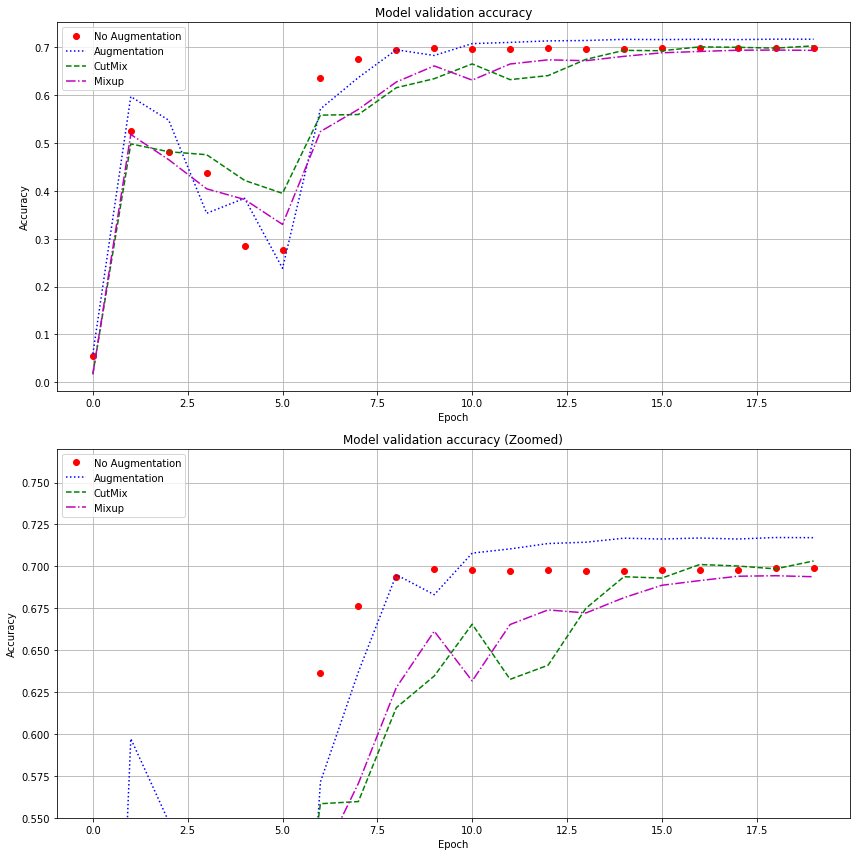

In [38]:
import matplotlib.pyplot as plt # 혹시 import 안 하셨다면 추가

# 훈련 과정 시각화
plt.figure(figsize=(12, 12))

plt.subplot(2, 1, 1)
# .history 삭제 및 변수명 수정
plt.plot(history_resnet50_no_aug['val_accuracy'], 'ro', label='No Augmentation')
plt.plot(history_resnet50_aug['val_accuracy'], 'b:', label='Augmentation')
plt.plot(history_resnet50_aug_cutmix['val_accuracy'], 'g--', label='CutMix') # 변수명 수정됨
plt.plot(history_resnet50_aug_mixup_model2['val_accuracy'], 'm-.', label='Mixup') # 변수명 수정됨

plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper left') # loc='upper left'는 이미 기본값일 수 있으나 명시
plt.grid(True)

plt.subplot(2, 1, 2)
# .history 삭제 및 변수명 수정
plt.plot(history_resnet50_no_aug['val_accuracy'], 'ro', label='No Augmentation')
plt.plot(history_resnet50_aug['val_accuracy'], 'b:', label='Augmentation')
plt.plot(history_resnet50_aug_cutmix['val_accuracy'], 'g--', label='CutMix') # 변수명 수정됨
plt.plot(history_resnet50_aug_mixup_model2['val_accuracy'], 'm-.', label='Mixup') # 변수명 수정됨

plt.title('Model validation accuracy (Zoomed)')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.grid(True)
plt.ylim(0.55, 0.770) # y축 범위 지정

plt.tight_layout() # subplot들이 겹치지 않도록 자동 레이아웃 조정
plt.show()

### Models Validation Loss

In [39]:
import matplotlib.pyplot as plt # 혹시 import 안 하셨다면 추가

# 훈련 과정 시각화 (Validation Loss)
plt.figure(figsize=(12, 12))

plt.subplot(2, 1, 1)
# .history 삭제 및 변수명 수정
plt.plot(history_resnet50_no_aug['val_loss'], 'ro-', label='No Augmentation') # 라인 스타일 변경 및 레이블 추가
plt.plot(history_resnet50_aug['val_loss'], 'b:o', label='Augmentation') # 라인 스타일 변경 및 레이블 추가
plt.plot(history_resnet50_aug_cutmix['val_loss'], 'g--o', label='CutMix') # 변수명 및 라인 스타일 변경, 레이블 추가
plt.plot(history_resnet50_aug_mixup_model2['val_loss'], 'm-.o', label='Mixup') # 변수명 및 라인 스타일 변경, 레이블 추가

plt.title('Model Validation Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right') # 범례 위치 변경 (loss는 보통 오른쪽 위에)
plt.grid(True)

plt.subplot(2, 1, 2)
# .history 삭제 및 변수명 수정
plt.plot(history_resnet50_no_aug['val_loss'], 'ro-', label='No Augmentation')
plt.plot(history_resnet50_aug['val_loss'], 'b:o', label='Augmentation')
plt.plot(history_resnet50_aug_cutmix['val_loss'], 'g--o', label='CutMix')
plt.plot(history_resnet50_aug_mixup_model2['val_loss'], 'm-.o', label='Mixup')

plt.title('Model Validation Loss (Zoomed)')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.grid(True)
plt.ylim(0.80, 1.80) # y축 범위 지정

plt.tight_layout() # subplot들이 겹치지 않도록 자동 레이아웃 조정
plt.show()

# 5. Augmentation에 의한 모델 성능 비교하기

No Augmentation, Baseline, Model 1, 그리고 Model 2의 훈련된 ResNet50 분류기의 견종 분류 정확도 성능을 비교해보고 Augmentation의 영향도에 대해서도 분석해보기.

### Validation Accuracy

In [40]:
import pandas as pd # 혹시 pandas import 안 하셨다면 추가

val_acc_dict = {
    'No Augmentation': history_resnet50_no_aug['val_accuracy'],  # .history 삭제
    'Augmentation': history_resnet50_aug['val_accuracy'],       # .history 삭제
    'CutMix': history_resnet50_aug_cutmix['val_accuracy'],     # .history 삭제 및 변수명 수정
    'Mixup': history_resnet50_aug_mixup_model2['val_accuracy'] # .history 삭제 및 변수명 수정
}

df1 = pd.DataFrame(val_acc_dict)
print("DataFrame of validation accuracies per epoch for each model:")
print(df1) # DataFrame 내용 확인

acc_mean = df1.mean()
print("\nMean validation accuracy for each model across all epochs:")
print(acc_mean) # 평균값 확인

DataFrame of validation accuracies per epoch for each model:
    No Augmentation  Augmentation  CutMix   Mixup
0            0.0549        0.0596  0.0178  0.0164
1            0.5260        0.5972  0.4983  0.5180
2            0.4813        0.5478  0.4819  0.4653
3            0.4377        0.3533  0.4757  0.4044
4            0.2852        0.3846  0.4220  0.3821
5            0.2759        0.2383  0.3949  0.3300
6            0.6364        0.5714  0.5584  0.5241
7            0.6763        0.6370  0.5597  0.5705
8            0.6937        0.6950  0.6157  0.6277
9            0.6983        0.6831  0.6346  0.6613
10           0.6976        0.7079  0.6655  0.6316
11           0.6975        0.7104  0.6326  0.6653
12           0.6978        0.7136  0.6410  0.6740
13           0.6972        0.7144  0.6750  0.6722
14           0.6973        0.7168  0.6938  0.6813
15           0.6979        0.7163  0.6930  0.6887
16           0.6980        0.7169  0.7011  0.6915
17           0.6978        0.7163  0.70

### Validation Loss

In [41]:
import pandas as pd # 혹시 pandas import 안 하셨다면 추가

val_loss_dict = {
    'No Augmentation': history_resnet50_no_aug['val_loss'],  # .history 삭제
    'Augmentation': history_resnet50_aug['val_loss'],       # .history 삭제
    'CutMix': history_resnet50_aug_cutmix['val_loss'],     # .history 삭제 및 변수명 수정
    'Mixup': history_resnet50_aug_mixup_model2['val_loss'] # .history 삭제 및 변수명 수정
}

df2 = pd.DataFrame(val_loss_dict)
print("DataFrame of validation losses per epoch for each model:")
print(df2) # DataFrame 내용 확인

loss_mean = df2.mean()
print("\nMean validation loss for each model across all epochs:")
print(loss_mean) # 평균값 확인

DataFrame of validation losses per epoch for each model:
    No Augmentation  Augmentation  CutMix   Mixup
0            4.6109        4.5248  5.0135  5.2838
1            1.7296        1.3866  1.8632  1.7392
2            2.0077        1.7202  1.9621  2.1183
3            2.4431        2.9383  1.9901  2.3049
4            3.3692        2.6908  2.2518  2.5064
5            3.6378        3.7456  2.4831  2.7874
6            1.4602        1.7964  1.7013  1.8441
7            1.3154        1.4621  1.7316  1.6599
8            1.2331        1.2344  1.5320  1.3987
9            1.2300        1.2912  1.4596  1.3093
10           1.2225        1.1893  1.3994  1.4531
11           1.2256        1.1854  1.5561  1.3389
12           1.2244        1.1692  1.5307  1.3100
13           1.2301        1.1662  1.4122  1.3171
14           1.2216        1.1659  1.3493  1.2875
15           1.2272        1.1694  1.3523  1.2735
16           1.2236        1.1658  1.3335  1.2684
17           1.2220        1.1679  1.3546  

### Results Among Overall Models Comparison

In [43]:
import pandas as pd # pandas가 이미 import 되어있겠지만, 혹시 모르니 추가합니다.

# acc_mean과 loss_mean 변수가 이전 단계에서 올바르게 계산되었다고 가정합니다.
# 만약 아직 계산하지 않으셨다면, 이전 답변의 코드를 먼저 실행해주세요.

# 예시: acc_mean과 loss_mean이 다음과 같이 계산되어 있다고 가정
# acc_mean = df1.mean() # df1은 val_accuracy로 만든 DataFrame
# loss_mean = df2.mean() # df2는 val_loss로 만든 DataFrame

# 두 Series를 합쳐서 비교 테이블(DataFrame) 만들기
comparison_df = pd.DataFrame({
    'Mean Validation Accuracy': acc_mean,
    'Mean Validation Loss': loss_mean
})

# 인덱스 이름 설정 (선택 사항이지만, 테이블 가독성을 높여줍니다)
comparison_df.index.name = 'Augmentation Type'

# 소수점 4자리까지 표시하도록 설정 (선택 사항)
pd.options.display.float_format = '{:.4f}'.format

# 결과 테이블 출력
print("Results Among Overall Models Comparison")
print(comparison_df)

Results Among Overall Models Comparison
                   Mean Validation Accuracy  Mean Validation Loss
Augmentation Type                                                
No Augmentation                      0.5872                1.7643
Augmentation                         0.5957                1.7252
CutMix                               0.5731                1.8000
Mixup                                0.5643                1.8008


# Evaluations and Reflections

Rubric

루브릭
아래의 기준을 바탕으로 프로젝트를 평가합니다.
평가문항	상세기준
1. CutMix와 MixUp 기법을 ResNet50 분류기에 성공적으로 적용하였는가?	CutMix와 MixUp을 적용한 데이터셋으로 훈련한 각각의 ResNet 모델이 수렴하였다.
2. 다양한 실험을 통해 태스크에 최적인 Augmentation 기법을 찾아내었는가?	각 Augmentation 기법을 적용하고, 그에 따른 성능 비교 분석 및 문제점을 서술하였음
3. 여러가지 Augmentation 기법을 적용한 결과를 체계적으로 비교분석하였는가?	기본 Augmentation, CutMix, MixUp이 적용된 결과를 시각화와 함께 체계적으로 분석하였다.


회고:
데이터셋을 만드는 과정에서 cutmix 와 mixup 데이터를 사용하는데 어려움이 있었습니다. 이미지 사이즈 혹은 부동소수점 및 정수 관련 이슈가 있어서, 그 문제를 해결 하는데 힘이 들었고, 따라서 function을 어떤걸 적용 시켜줘야 되는지에대한 어려움이 있었던것 같습니다. 또한 모델을 훈련하는 과정에서 4개의 모델을 비교 했을 때, 어떤 상황에서 모델을 서로 비교하고 왜 사용할지에 대한 고민을 했던것 같습니다.